Name: Josemaria Macedo Carrillo\
Ttile: Land Matrix Data Exploration\
Created: 08/07/23\
Last modified: 09/07/23\
DSI

The purpose of this notebook is to analyze data on Ukrainian agricultural
exports for October 2022 (busiest month according to BSGI). The main data sources
are the Black Sea Grain Initiative (BSGI) of the United
Nations and Import Genius (IG), a website that has trade data for different countries
including Ukraine.

In [1]:
import sys
sys.path.append('..')
import pandas as pd
from utils.get_data import get_data, import_data
from utils.record_linkage import rl_ig_bsgi
from utils.plot import cargo_grouping, plot_line, plot_crops, plot_pie, plot_stack_bar
from utils.clean_data import PRODUCTS_VAL, translate_column, rename_columns, create_columns, clean_column
from utils.transform_data import estimate_weights, standard_company_name, create_wide_table
from utils.record_linkage import record_linkage, unique_matches, filter_crop, find_matches
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator
import numpy as np

Import cleaned data from Import Genius (IG) and the Black Sea Grain Initiative
(BSGI) with all the necessary columns for further analysis.

In [2]:
ig = get_data("ig")
bsgi = get_data("bsgi")

In [3]:
ig_oct = ig.loc[(ig.loc[:, "date"] >= "2022-10-01") & (ig.loc[:, "date"] < "2022-11-01")]
bsgi_oct = bsgi.loc[(bsgi.loc[:, "date"] >= "2022-10-01") & (bsgi.loc[:, "date"] < "2022-11-01")]

We estimate the shares of total exports by company.

bsgi_weight:  4241809
ig_weight:  1191434.89292
Values passed to ax.pie:
 12    3.050374e+06
4     5.159455e+05
2     2.352917e+05
5     2.198016e+05
8     8.784659e+04
6     6.252277e+04
1     3.623030e+04
3     1.288057e+04
7     1.236582e+04
10    5.115967e+03
9     1.497040e+03
0     1.178965e+03
11    7.580190e+02
Name: weight_ton, dtype: float64


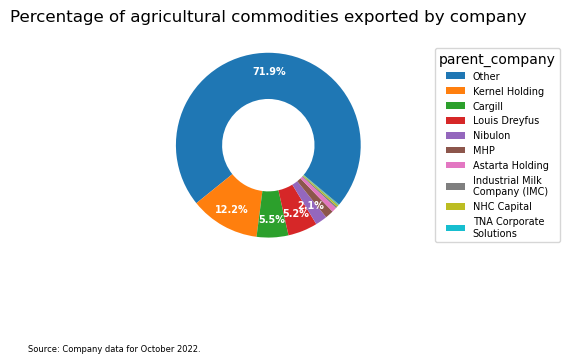

,parent_company,weight_ton
12,Other,3.050374e+06
4,Kernel Holding,5.159455e+05
2,Cargill,2.352917e+05
5,Louis Dreyfus,2.198016e+05
8,Nibulon,8.784659e+04
6,MHP,6.252277e+04
1,Astarta Holding,3.623030e+04
3,Industrial Milk \nCompany (IMC),1.288057e+04
7,NHC Capital,1.236582e+04
10,TNA Corporate \nSolutions,5.115967e+03


In [4]:
estimate_weights(ig_oct, "parent_company", "weight_ton", bsgi_oct, "weight_ton", "Percentage of agricultural commodities exported by company", crop=None)

Now we estimate the shares of exports by company for all countries included in Import Genius that get exports from Ukraine.

bsgi_weight:  82000
ig_weight:  41346.619
Values passed to ax.pie:
 0    41346.619
1    40653.381
Name: weight_ton, dtype: float64


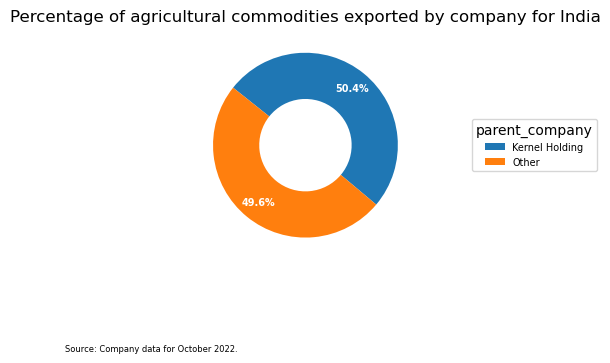

bsgi_weight:  116789
ig_weight:  0.0
Values passed to ax.pie:
 0    116789.0
Name: weight_ton, dtype: float64


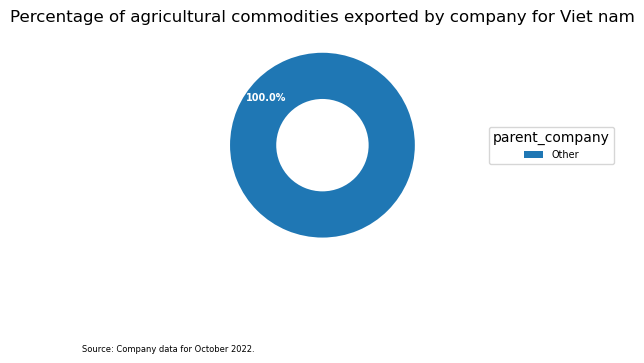

In [5]:
# First we create a dictionary with the country names in English and lowercase as
# keys (for BSGI) and the country names in ukrainian and lowercase as values (for IG)
# country_d = {"india": "індія", "viet nam": "в єтнам", "sri lanka": "шрі ланка"}
country_d = {"india": "індія", "viet nam": "в єтнам"}

for country_en, country_uk in country_d.items():
    ig_country = ig_oct.loc[ig_oct.loc[:, "country"] == country_uk]
    bsgi_country = bsgi_oct.loc[bsgi_oct.loc[:, "country_en"] == country_en]
    estimate_weights(ig_country, "parent_company", "weight_ton", bsgi_country, "weight_ton", f"Percentage of agricultural commodities exported by company for {country_en.capitalize()}", crop=None)

In [6]:
# Check who's exporting to Vietnam in October 2022 (IG)
ig_vietnam = ig_oct.loc[ig_oct.loc[:, "country"] == "в єтнам"]
ig_vietnam
bsgi_vietnam = bsgi_oct.loc[bsgi_oct.loc[:, "country_en"] == "viet nam"]
bsgi_vietnam

,status,,vessel_name,imo,departure_port,country_en,product,weight_ton,date,inspection_cleared,...,un_region,development_category,wfp,stranded,year,month,product_std,hs_code,product_std_gt,country
717,Outbound,381,C FAITH,9575163,Odesa,viet nam,wheat,56789,2022-10-24,31-Oct-2022,...,Asia-Pacific,developing,NaN,NaN,2022,10,wheat,1001,пшениця,в'єтнам
819,Outbound,287,CORNELIA M,9490117,Yuzhny/Pivdennyi,viet nam,wheat,60000,2022-10-08,31-Oct-2022,...,Asia-Pacific,developing,NaN,NaN,2022,10,wheat,1001,пшениця,в'єтнам


Now we estimate the shares for all countries included in IG (India and Vietnam)

bsgi_weight:  198789
ig_weight:  41346.619
Values passed to ax.pie:
 1    157442.381
0     41346.619
Name: weight_ton, dtype: float64


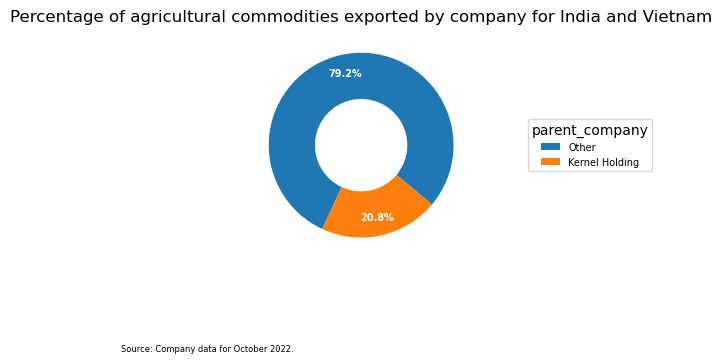

,parent_company,weight_ton
1,Other,157442.381
0,Kernel Holding,41346.619


In [7]:
ig_country = ig_oct.loc[(ig_oct.loc[:, "country"] == "індія") | (ig_oct.loc[:, "country"] == "в єтнам")]
bsgi_country = bsgi_oct.loc[(bsgi_oct.loc[:, "country_en"] == "india") | (bsgi_oct.loc[:, "country_en"] == "viet nam")]
estimate_weights(ig_country, "parent_company", "weight_ton", bsgi_country, "weight_ton", f"Percentage of agricultural commodities exported by company for India and Vietnam", crop=None)

Now we estimate the shares of exports for India, Vietnam and Sri Lanka from August 2022 (beginning of BSGI) until March 2023 (end of IG) for all companies.

In [8]:
# First we import the csv file
ig_asia = import_data("/Users/jmacedoc/Documents/DSI/Ukraine Agricultural Exports/oakland-institute-ukraine/data/ig_all_22-23.csv", "ig")
ig_asia["company_searched"] = ig_asia["SHIPPER"]
ig_asia = rename_columns(ig_asia, "ig")

ig_asia["year"] = ig_asia["date"].dt.year
ig_asia["month"] = ig_asia["date"].dt.month

ig_asia["weight_ton"] = ig_asia["weight_kg"] / 1000
product_std = set(PRODUCTS_VAL)
# We create a variable that sums the number of products mentioned in the
# product name
ig_asia["n_products"] = 0
for product in product_std:
    product_uk = GoogleTranslator("en", "uk").translate(product)
    ig_asia[product] = ig_asia["product"].apply(lambda x: True if product_uk in x.lower() else False)
    ig_asia["n_products"] += ig_asia[product]

columns = ["country", "product"]
for col in columns:
    clean_column(ig_asia, col)

In [9]:
ig_asia["country"].unique()

array(["в'єтнам", 'індія', 'шрі-ланка', 'в єтнам', 'шрі ланка'],
      dtype=object)

We transform the country strings to the correct ones manually. This should be done
after doing record linkage but since we're not doing that we'll do it manually and then add it to
a function.

In [10]:
correct_name = {"в'єтнам": "в єтнам", "в єтнам": "в єтнам", "індія": "індія", "шрі-ланка": "шрі ланка", "шрі ланка": "шрі ланка"}
ig_asia["country"] = ig_asia["country"].apply(lambda x: correct_name[x])
ig_asia.columns

Index(['product', 'hs_code', 'consignee', 'consignee_address', 'shipper',
       'shipper_address', 'date', 'quantity', 'weight_kg', 'invoice_price_uah',
       'total_invoice_value_usd', 'invoice_price_in_kilograms_usd',
       'item_unit', 'item_number', 'customs_value', 'customs_office_code',
       'country_of_origin', 'country', 'place_of_delivery', 'delivery_terms',
       'declaration_no', 'currency_ratio', 'sender_code', 'bank_name',
       'company_searched', 'year', 'month', 'weight_ton', 'n_products',
       'sugar beet', 'barley', 'corn', 'soya', 'vegetable', 'peas', 'canola',
       'wheat', 'mixed', 'rapeseed', 'sunflower'],
      dtype='object')

Now we filter just exports for crops that are included in BSGI so we can compare the volumes (otherwise we'll include exports for other commodities like metals that are included in IG but that aren't included in BSGI)

In [11]:
HS_DICT = {"1205": "Rapeseed", "2306": "Rapeseed meal", "1514": "Canola",
           "1005": "Corn", "1512": "Sunflower oil", "1206": "Sunflower seed",
            "2306": "Sunflower pellets", "2306": "Sunflower meal",
          "1001":  "Wheat", "1201": "Soya beans", "1507": "Soya oil",
          "1003":  "Barley", "0713": "Peas", "1516": "Vegetable oil",
           "2302": "Wheat bran pellets", "2302": "Sugar beet pellets"}

ig_asia["hs_code_2"] = ig_asia["hs_code"].str[:4]

ig_asia["bsgi_commodity"] = ig_asia["hs_code_2"].apply(lambda x: HS_DICT[x] if x in HS_DICT else "Not in BSGI")

ig_asia = ig_asia[ig_asia["bsgi_commodity"]!= "Not in BSGI"]

print("IG tons:",ig_asia.loc[ig_asia.loc[:, "country"] == "в єтнам"]["weight_ton"].sum())
print("BSGI tons:",bsgi.loc[bsgi.loc[:, "country_en"] == "viet nam"]["weight_ton"].sum())

IG tons: 174997.27360000001
BSGI tons: 168789


We filter the BSGI data to include only months that are included in our IG data (August 2022 until March 2023)

In [12]:
bsgi_asia = bsgi[(bsgi["date"] >= "2022-08-01") & (bsgi["date"] < "2023-04-01") & ((bsgi["country_en"] == "india") | (bsgi["country_en"] == "viet nam") | (bsgi["country_en"] == "sri lanka"))]
bsgi_asia.head()

,status,,vessel_name,imo,departure_port,country_en,product,weight_ton,date,inspection_cleared,...,un_region,development_category,wfp,stranded,year,month,product_std,hs_code,product_std_gt,country
170,Outbound,857,PS QUEEN,9358319,Yuzhny/Pivdennyi,india,sunflower oil,42000,2023-03-30,9-Apr-2023,...,Asia-Pacific,developing,NaN,NaN,2023,3,sunflower,1512,соняшник,індія
198,Outbound,834,IOANNIS THEO,9565170,Odesa,viet nam,wheat,52000,2023-03-22,3-Apr-2023,...,Asia-Pacific,developing,NaN,NaN,2023,3,wheat,1001,пшениця,в'єтнам
313,Outbound,737,SEA MAJESTIC,9391153,Chornomorsk,india,sunflower oil,19176,2023-02-14,19-Feb-2023,...,Asia-Pacific,developing,NaN,NaN,2023,2,sunflower,1512,соняшник,індія
318,Outbound,732,OCEAN GLSR,9529516,Yuzhny/Pivdennyi,sri lanka,wheat,54268,2023-02-12,24-Feb-2023,...,Asia-Pacific,developing,NaN,NaN,2023,2,wheat,1001,пшениця,шрі ланка
394,Outbound,666,MRC SEDEF,9335032,Chornomorsk,india,sunflower oil,43000,2023-01-20,31-Jan-2023,...,Asia-Pacific,developing,NaN,NaN,2023,1,sunflower,1512,соняшник,індія


Now we estimate the export shares by country

bsgi_weight:  454286
ig_weight:  405719.77599999995
Values passed to ax.pie:
 28     58324.200
113    48566.224
36     48000.000
39     42895.420
5      23874.420
         ...    
41        30.230
38        24.840
3         22.760
66        19.400
79        19.200
Name: weight_ton, Length: 114, dtype: float64


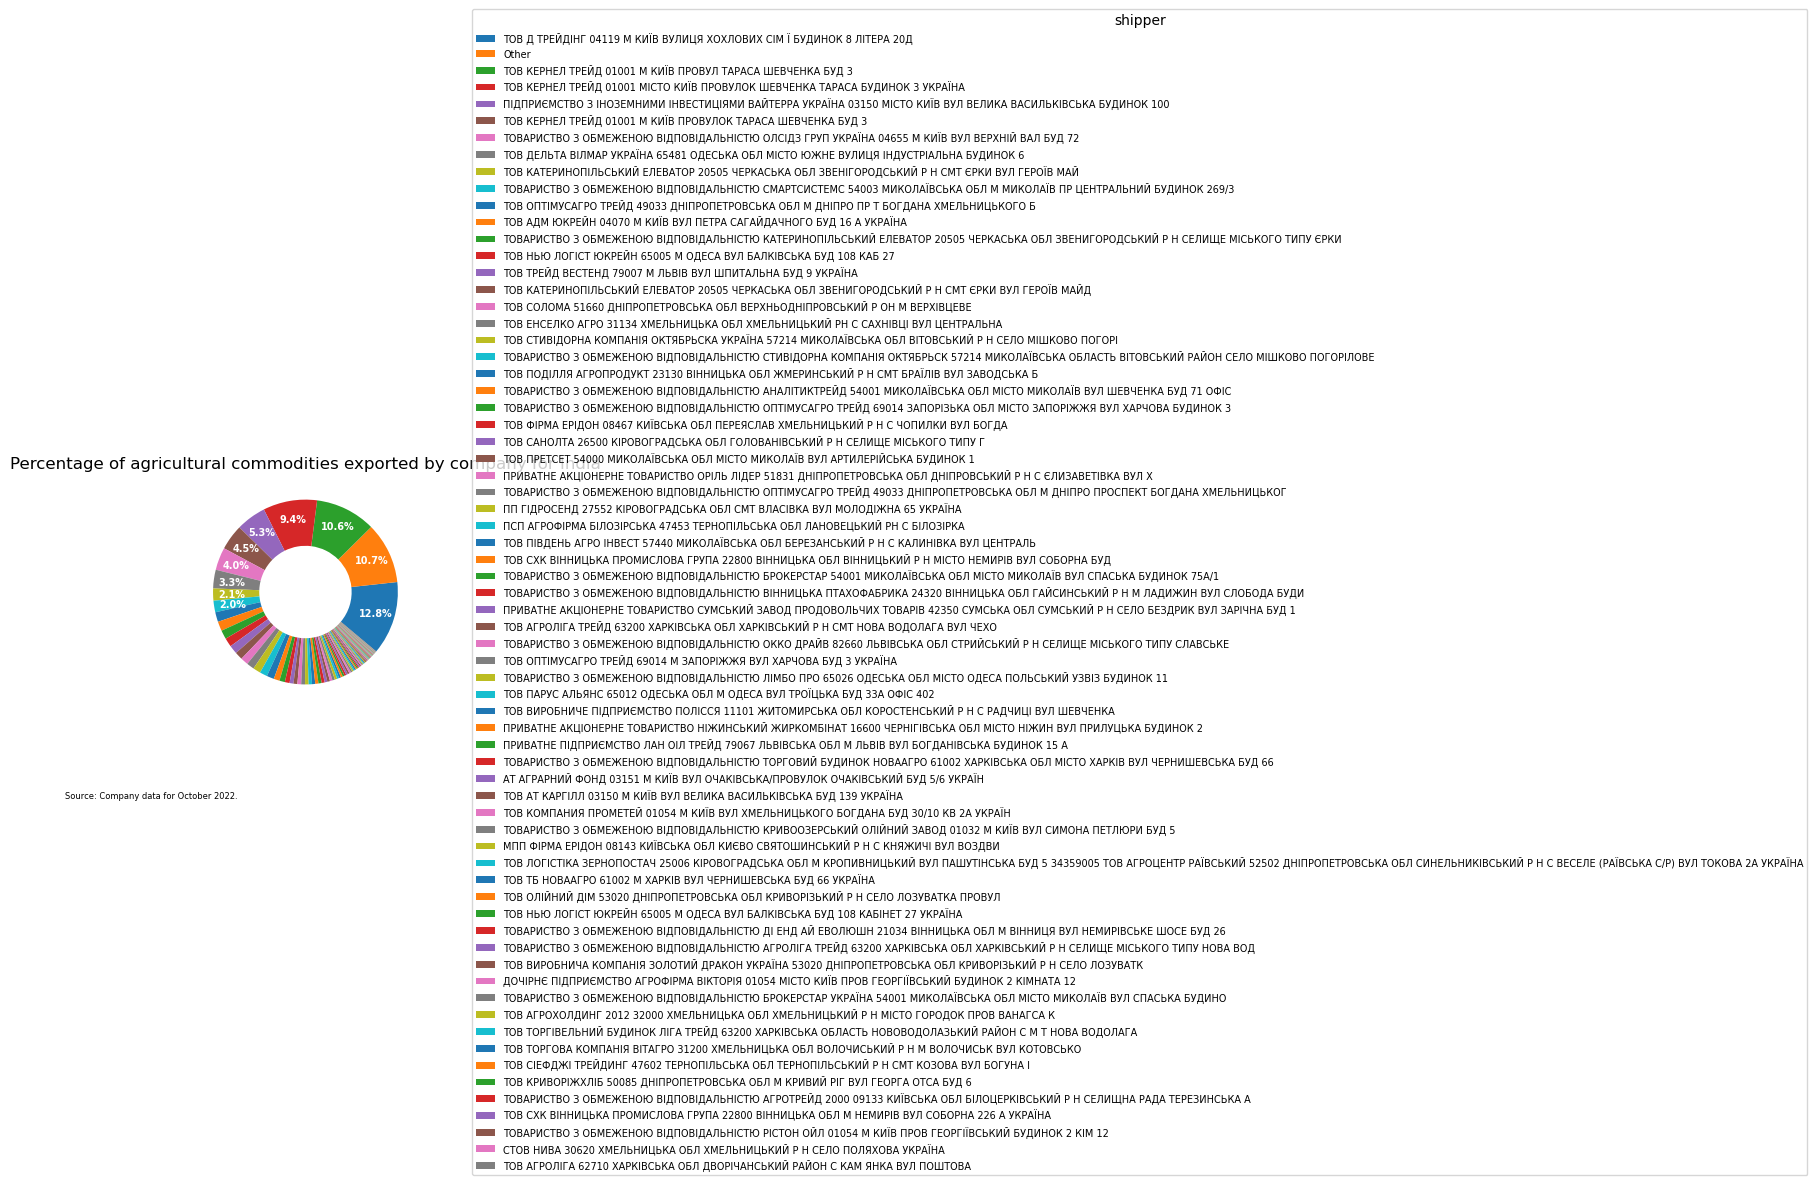

bsgi_weight:  168789
ig_weight:  174997.27360000001
Values passed to ax.pie:
 20    21447.1000
30    21151.7900
26    12001.5400
41    10457.4910
2      8742.4300
         ...    
47       25.4290
48       24.4110
56       24.3500
0        23.5000
86    -6208.2736
Name: weight_ton, Length: 87, dtype: float64


ValueError: Wedge sizes 'x' must be non negative values

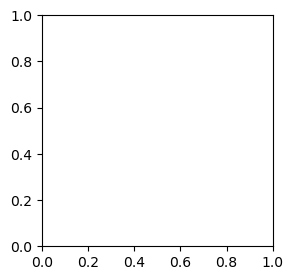

In [13]:
country_d = {"india": "індія", "viet nam": "в єтнам", "sri lanka": "шрі ланка"}

for country_en, country_uk in country_d.items():
    ig_country = ig_asia.loc[ig_asia.loc[:, "country"] == country_uk]
    bsgi_country = bsgi_asia.loc[bsgi_asia.loc[:, "country_en"] == country_en]
    df = estimate_weights(ig_country, "shipper", "weight_ton", bsgi_country, "weight_ton", f"Percentage of agricultural commodities exported by company for {country_en.capitalize()}", crop=None)

In [14]:
df.head()

,shipper,weight_ton
28,ТОВ Д ТРЕЙДІНГ 04119 М КИЇВ ВУЛИЦЯ ХОХЛОВИХ СІ...,58324.200
113,Other,48566.224
36,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛ ТАРАСА ШЕ...,48000.000
39,ТОВ КЕРНЕЛ ТРЕЙД 01001 МІСТО КИЇВ ПРОВУЛОК ШЕВ...,42895.420
5,ПІДПРИЄМСТВО З ІНОЗЕМНИМИ ІНВЕСТИЦІЯМИ ВАЙТЕРР...,23874.420


## TOTAL EXPORTS BY COMPANY

### STACKED BAR CHARTS

We have to create a column with standardized company names.

In [15]:
known_companies = {"Kernel": ["ДРУЖБА НОВА", "ЕНСЕЛКО АГРО", "ПОДІЛЛЯ АГРОСЕРВІС", "КЕРНЕЛ"], "UkrLandFarming": ["VALINOR", "ДАКОР", "УКРЛЕНДФАРМІНГ", "ЮГТРАНЗИТСЕРВИС-АГРОПРОДУКТ", "АГРОКОМПАНІЯ ПРИКАРПАТТЯ"], "MHP": ["МХП"], "TNA Corporate Solutions": ["ПІВДЕНЬ АГРО ІНВЕСТ", "ПТАХОФАБРИКА ПОДІЛЛЯ", "ПРИДНІПРОВСЬКА", "РАЙЗ-МАКСИМКО", "ПРИДНІПРОВСЬКЕ"], "NHC Capital": ["АГРОПРОСПЕРІС"], "Astarta Holding": ["АСТАРТА", "ДОБРОБУТ", "ПОЛТАВАЗЕРНОПРОДУКТ", "ХМІЛЬНИЦЬКЕ", "АГРО КА"], "Industrial Milk Company": ["АГРОПРОГРЕС", "СЛОБОЖАНЩИНА АГРО", "АГРОКІМ", "БУРАТ АГРО", "ЛОСИНІВКА АГРО", "ИМЦ"], "PIF Saudi Arabia": ["SALIC", "АГРО ЛВ", "МРІЯ ФАРМІНГ"], "Agroton Public Limited": ["АГРОТОН"], "Nibulon": ["НІБУЛОН"], "System Capital Management": ["АГРО ХОЛДИНГ МС", "CARGILL", "LOUIS DREYFUS"]}
ig_c = ig_asia.copy()
ig_c["company_std"] = standard_company_name(ig_asia["shipper"], known_companies)
ig_c["company_std"].unique()

array(['Other', 'Astarta Holding', 'Kernel', 'TNA Corporate Solutions'],
      dtype=object)

Now we convert the dataframe to a wide format so we can plot the stacked bar.

In [16]:
pivot = create_wide_table(ig_c, ["year", "month", "company_std"], ["weight_ton"], ["year", "month", "company_std"], True, {"weight_ton": "sum"})
pivot

company_std,date,Astarta Holding,Kernel,Other,TNA Corporate Solutions
6,8/2022,NaN,NaN,480.5,NaN
7,9/2022,NaN,19000.0,79885.5,2561.6
1,10/2022,NaN,41346.6,163093.8,NaN
2,11/2022,NaN,NaN,16395.7,NaN
3,12/2022,NaN,26390.9,69823.7,NaN
0,1/2023,9116.3,30556.6,91712.2,NaN
4,2/2023,NaN,NaN,74775.0,NaN
5,3/2023,289.8,NaN,62447.7,NaN


In [32]:
percentages = pivot.copy()
percentages = percentages.fillna(0)
percentages["total_exports"] = percentages["Astarta Holding"] + percentages["Kernel"] + percentages["Other"] + percentages["TNA Corporate Solutions"]
percentages["kernel_p"] = percentages["Kernel"] / percentages["total_exports"] * 100
percentages = percentages.round(1)
print("Kernel percentage average in months when it exports: ", percentages["kernel_p"].sum()/4)
percentages
percentages["kernel_p"].mean()

Kernel percentage average in months when it exports:  22.4


11.2

Now we plot the stacked bar with our wide format table we created earlier.

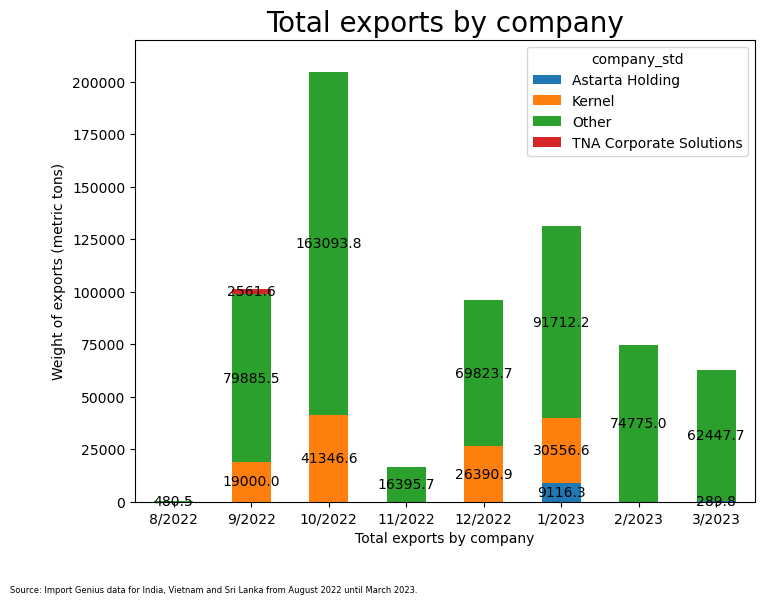

In [17]:
plot_stack_bar(pivot, "Total exports by company", "Weight of exports (metric tons)", "Total exports by company", "date", 220000, "Import Genius data for India, Vietnam and Sri Lanka from August 2022 until March 2023")

We plot the same stacked bars but now by country

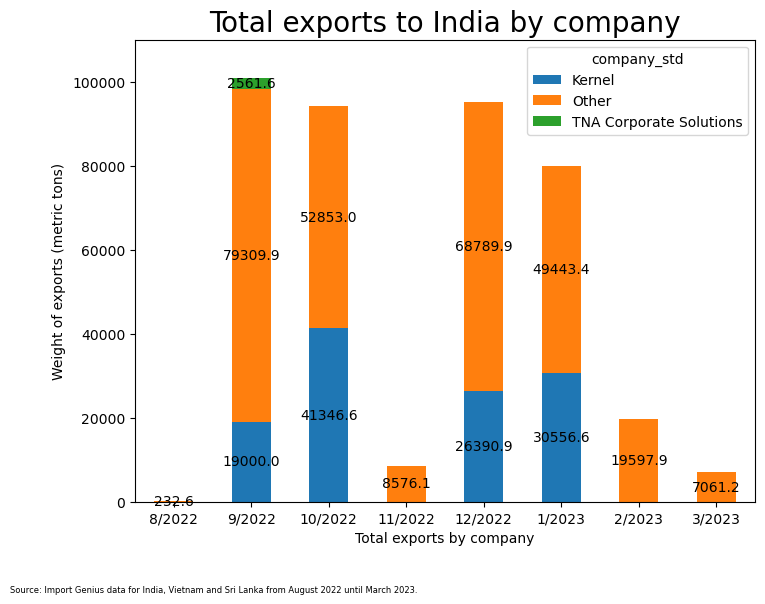

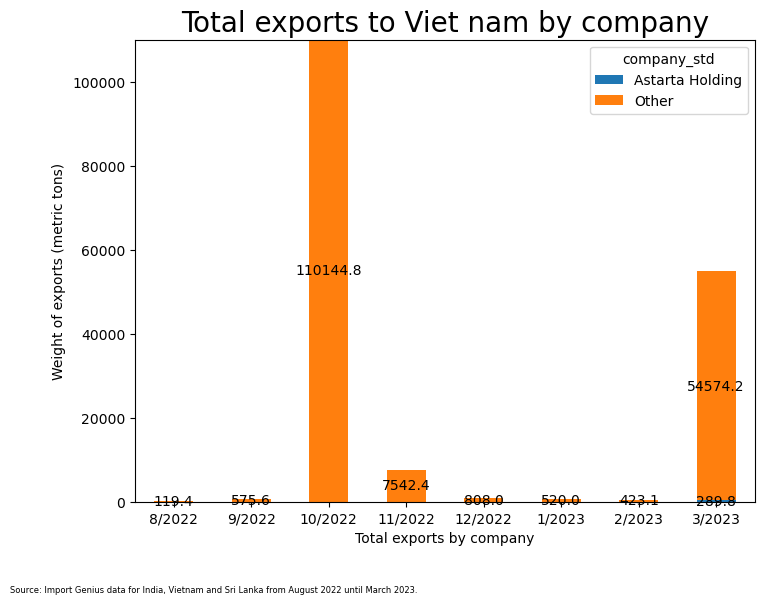

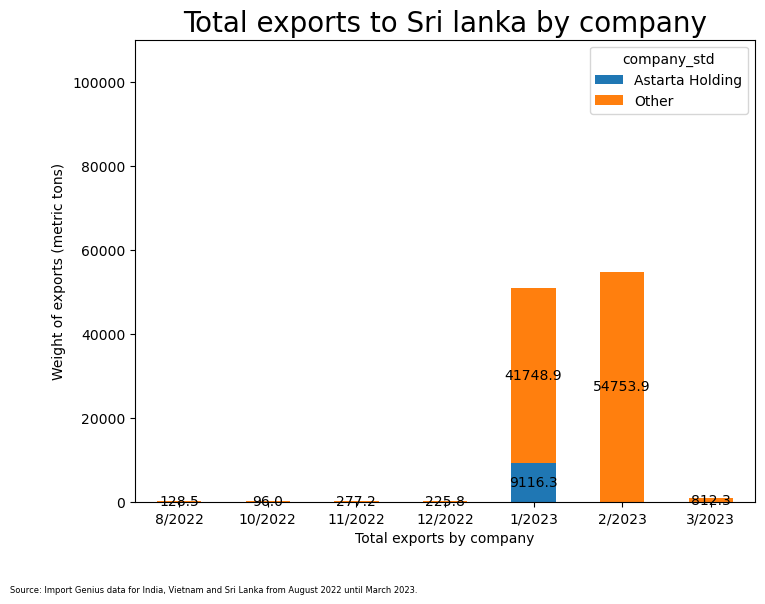

In [18]:
country_d = {"india": "індія", "viet nam": "в єтнам", "sri lanka": "шрі ланка"}

for country_en, country_uk in country_d.items():
    ig_country = ig_c[ig_c["country"] == country_uk]
    pivot_country = create_wide_table(ig_country, ["year", "month", "company_std"], ["weight_ton"], ["year", "month", "company_std"], True, {"weight_ton": "sum"})
    plot_stack_bar(pivot_country, "Total exports by company", "Weight of exports (metric tons)", f"Total exports to {country_en.capitalize()} by company", "date", 110000, "Import Genius data for India, Vietnam and Sri Lanka from August 2022 until March 2023")

### TABLE WITH EXPORTS BY COMPANY (ALL COMPANIES INCLUDED)

Now we get the same table but with the specific companies that are not in the top 10 disaggregated.

In [20]:
ig_c["company_all"] = ig_c["company_std"]
for idx, row in ig_c.iterrows():
    if row["company_std"] == "Other":
        ig_c["company_all"][idx] = ig_c["shipper"][idx]

/var/folders/j4/m2rbwhqs6yq26cq7rc0g4cm80000gn/T/ipykernel_3911/2768725281.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ig_c["company_all"][idx] = ig_c["shipper"][idx]
/var/folders/j4/m2rbwhqs6yq26cq7rc0g4cm80000gn/T/ipykernel_3911/2768725281.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ig_c["company_all"][idx] = ig_c["shipper"][idx]
/var/folders/j4/m2rbwhqs6yq26cq7rc0g4cm80000gn/T/ipykernel_3911/2768725281.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [21]:
ig_all_comp = cargo_grouping(ig_c, ["year", "month", "company_all"], ["weight_ton"], ["year", "month", "weight_ton"], True, {"weight_ton": "sum"})
ig_all_comp["date"] = ig_all_comp["month"].astype(str) + "/" + ig_all_comp["year"].astype(str)
ig_all_comp = ig_all_comp.sort_values(by=["year", "month", "weight_ton"], ascending=[True, True, False])
translate_column(ig_all_comp, "company_all", "google", source="uk", target="en")

In [41]:
ig_all_translate = ig_all_comp[["date", "company_all", "company_all_gt", "weight_ton"]]
ig_all_translate.to_csv('../data/total_exports_by_company.csv', index=False)
ig_all_translate[ig_all_translate["date"] == "10/2022"].head
len(ig_all_translate["company_all"].unique())

261

### DIFFERENCE IN EXPORTS BETWEEN IG AND BSGI

We do some analysis to see why we have differences in weights between IG and BSGI

In [23]:
ig_g = cargo_grouping(ig_c, ["year", "month"], ["weight_ton"], ["year", "month"], True, {"weight_ton": "sum"}).rename(columns={"weight_ton": "IG"})
ig_g["date"] = ig_g["month"].astype(str) + "/" + ig_g["year"].astype(str)
ig_g = ig_g.drop(['year', 'month'], axis=1)
ig_g = ig_g[["date", "IG"]]

bsgi_g = cargo_grouping(bsgi_asia, ["year", "month"], ["weight_ton"], ["year", "month"], True, {"weight_ton": "sum"}).rename(columns={"weight_ton": "BSGI"})
bsgi_g["date"] = bsgi_g["month"].astype(str) + "/" + bsgi_g["year"].astype(str)
bsgi_g = bsgi_g.drop(['year', 'month'], axis=1)
bsgi_g = bsgi_g[["date", "BSGI"]]

final = ig_g.merge(bsgi_g, on="date", suffixes=("_ig", "_bsgi")).round(1)
final

,date,IG,BSGI
0,8/2022,480.5,19100
1,9/2022,101447.0,106500
2,10/2022,204440.4,198789
3,11/2022,16395.7,6010
4,12/2022,96214.6,136500
5,1/2023,131385.2,92500
6,2/2023,74775.0,73444
7,3/2023,62737.6,94000


Text(-90, -60, 'Source: IG and BSGI exports to India, Vietnam and Sri Lanka from August 2022 until March 2023.')

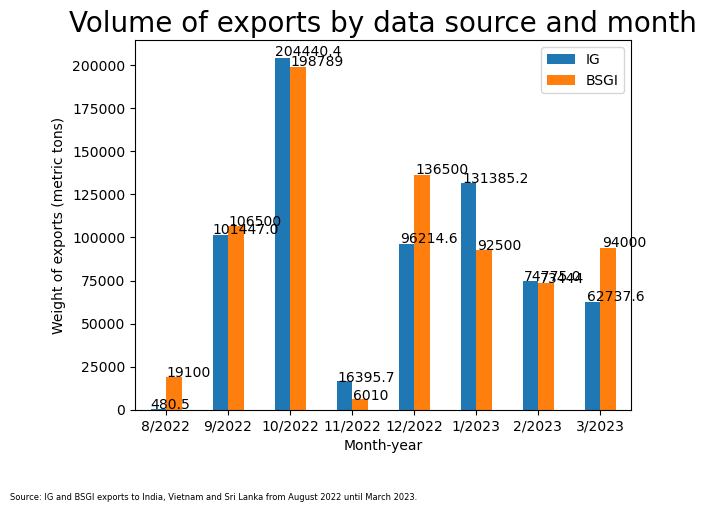

In [24]:
ax = final.plot.bar(rot=0)
ax.set_title("Volume of exports by data source and month", fontsize=20)
ax.set_xticklabels(final["date"], rotation=0)
ax.set_xlabel("Month-year")
ax.set_ylabel("Weight of exports (metric tons)")
for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
ax.annotate(f"Source: IG and BSGI exports to India, Vietnam and Sri Lanka from August 2022 until March 2023.", (0,0), (-90,-60), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points', va='top')

We do the same for Vietnam

In [36]:
ig_vietnam = ig_c.loc[ig_c.loc[:, "country"] == "в єтнам"]
ig_g = cargo_grouping(ig_vietnam, ["year", "month"], ["weight_ton"], ["year", "month"], True, {"weight_ton": "sum"}).rename(columns={"weight_ton": "IG"})
ig_g["date"] = ig_g["month"].astype(str) + "/" + ig_g["year"].astype(str)
ig_g = ig_g.drop(['year', 'month'], axis=1)
ig_g = ig_g[["date", "IG"]]

bsgi_vietnam = bsgi_asia.loc[bsgi_asia.loc[:, "country_en"] == "viet nam"]
bsgi_g = cargo_grouping(bsgi_vietnam, ["year", "month"], ["weight_ton"], ["year", "month"], True, {"weight_ton": "sum"}).rename(columns={"weight_ton": "BSGI"})
bsgi_g["date"] = bsgi_g["month"].astype(str) + "/" + bsgi_g["year"].astype(str)
bsgi_g = bsgi_g.drop(['year', 'month'], axis=1)
bsgi_g = bsgi_g[["date", "BSGI"]]

final = ig_g.merge(bsgi_g, on="date", how="outer", suffixes=("_ig", "_bsgi")).round(1)
final

,date,IG,BSGI
0,8/2022,119.4,NaN
1,9/2022,575.6,NaN
2,10/2022,110144.8,116789.0
3,11/2022,7542.4,NaN
4,12/2022,808.0,NaN
5,1/2023,520.0,NaN
6,2/2023,423.1,NaN
7,3/2023,54864.0,52000.0


Text(-90, -60, 'Source: IG and BSGI exports to Vietnam from August 2022 until March 2023.')

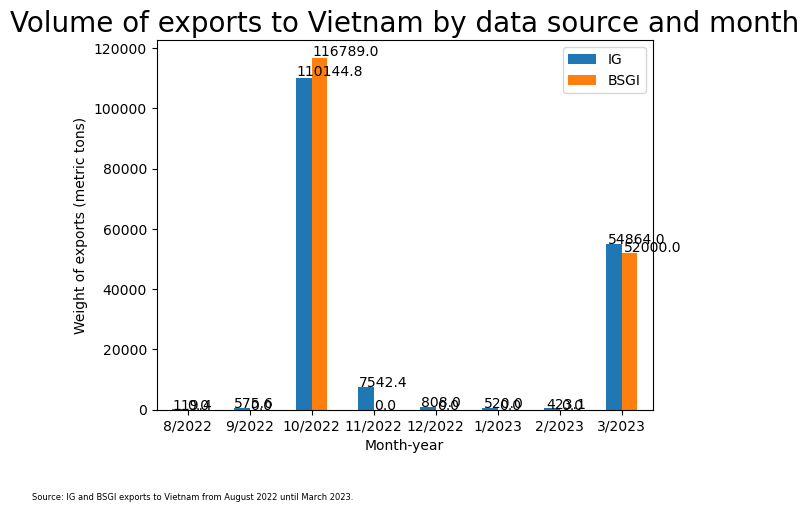

In [39]:
ax = final.plot.bar(rot=0)
ax.set_title("Volume of exports to Vietnam by data source and month", fontsize=20)
ax.set_xticklabels(final["date"], rotation=0)
ax.set_xlabel("Month-year")
ax.set_ylabel("Weight of exports (metric tons)")
for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
ax.annotate(f"Source: IG and BSGI exports to Vietnam from August 2022 until March 2023.", (0,0), (-90,-60), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points', va='top')

In [ ]:
print("IG tons:",ig_asia.loc[ig_asia.loc[:, "country"] == "шрі ланка"]["weight_ton"].sum())
print("BSGI tons:",bsgi_asia.loc[bsgi_asia.loc[:, "country_en"] == "sri lanka"]["weight_ton"].sum())

IG tons: 107158.925
BSGI tons: 103768


In [ ]:
print("IG tons:",ig_asia.loc[ig_asia.loc[:, "country"] == "в єтнам"]["weight_ton"].sum())
print("BSGI tons:",bsgi_asia.loc[bsgi_asia.loc[:, "country_en"] == "viet nam"]["weight_ton"].sum())

IG tons: 174997.27360000001
BSGI tons: 168789


In [ ]:
dates = ["2022-08-01", "2022-09-01", "2022-10-01", "2022-11-01", "2022-12-01", "2023-01-01", "2023-02-01", "2023-03-01", "2023-04-01"]
ig_test = ig_asia[ig_asia["bsgi_commodity"]!= "Not in BSGI"]
for i in range(len(dates)-1):
    ig_oct = ig_test.loc[(ig_test.loc[:, "date"] >= dates[i]) & (ig_test.loc[:, "date"] < dates[i+1])]
    bsgi_oct = bsgi_asia.loc[(bsgi_asia.loc[:, "date"] >= dates[i]) & (bsgi_asia.loc[:, "date"] < dates[i+1])]
    print(dates[i])
    print("IG tons:", ig_oct.loc[ig_oct.loc[:, "country"] == "в єтнам"]["weight_ton"].sum())
    print("BSGI tons:",bsgi_oct.loc[bsgi_oct.loc[:, "country_en"] == "viet nam"]["weight_ton"].sum())

2022-08-01
IG tons: 119.36
BSGI tons: 0
2022-09-01
IG tons: 575.6
BSGI tons: 0
2022-10-01
IG tons: 110144.78000000001
BSGI tons: 116789
2022-11-01
IG tons: 7542.38
BSGI tons: 0
2022-12-01
IG tons: 808.0
BSGI tons: 0
2023-01-01
IG tons: 520.0
BSGI tons: 0
2023-02-01
IG tons: 423.11359999999996
BSGI tons: 0
2023-03-01
IG tons: 54864.04
BSGI tons: 52000


In [ ]:
bsgi.loc[(bsgi.loc[:, "date"] >= "2022-10-01") & (bsgi.loc[:, "date"] < "2022-11-01") & (bsgi.loc[:, "country_en"] == "viet nam")].head()

,status,,vessel_name,imo,departure_port,country_en,product,weight_ton,date,inspection_cleared,...,un_region,development_category,wfp,stranded,year,month,product_std,hs_code,product_std_gt,country
717,Outbound,381,C FAITH,9575163,Odesa,viet nam,wheat,56789,2022-10-24,31-Oct-2022,...,Asia-Pacific,developing,NaN,NaN,2022,10,wheat,1001,пшениця,в'єтнам
819,Outbound,287,CORNELIA M,9490117,Yuzhny/Pivdennyi,viet nam,wheat,60000,2022-10-08,31-Oct-2022,...,Asia-Pacific,developing,NaN,NaN,2022,10,wheat,1001,пшениця,в'єтнам


In [ ]:
bsgi.loc[(bsgi.loc[:, "date"] >= "2022-10-01") & (bsgi.loc[:, "date"] < "2022-11-01") & (bsgi.loc[:, "country_en"] == "viet nam")].head()